<a href="https://colab.research.google.com/github/KimJaehee0725/pytorch-studying/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 드라이브 연결

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## 패키지 임포트

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [ ]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= True,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), #이미지 64x64로 크기 변환
                                                     transforms.ToTensor(), #텐서자료형으로 변환
                                                     transforms.Normalize((0.5,), (0.5,)), #노말라이즈를 통해 -1.~1.의 값을 갖게 변환
                     ]))

### 데이터 확인하기

In [ ]:
print('number of training data: ', len(dataset)) #데이터 수 확인 6만개
image,_ = dataset[0]

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기 채널 수는 1개이다. 

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


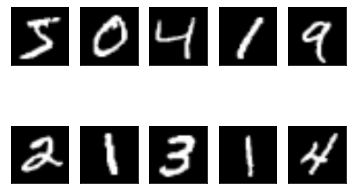

In [ ]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i]
    image = (image+1)/2
    image = image.squeeze()
    np_img = image.numpy()
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [ ]:
# dataloader
batch_size = 128 # 논문 참고
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

## device 정의

In [ ]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) #gpu 사용

cuda:0


## 신경망 

In [ ]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training images
nz = 100 # size of z latent vector #논문 내 fig1 참고
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator


### 신경망 가중치 초기화 함수 정의
https://www.javaer101.com/ko/article/1010427.html

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: # 해당 레이어에 conv라는 단어가 있다면, 즉 Convolution layer 라면 N(0, 0.02)로 가중치 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1: # batch norm 레이어는 N(1, 0.02)로, 편향은 0으로 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
          nn.ConvTranspose2d(in_channels = nz, out_channels = 1024, kernel_size = 4, stride = 1, padding = 0, bias = False), # 노이즈 벡터인 z를 받는다. 
          nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace = True),
          nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace = True),
          nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace = True),
          nn.ConvTranspose2d(in_channels = 128, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias = False), # mnist gray scale이기 때문에 channel은 1, 생성자의 마지막 레이어는 bm 생략
          nn.Tanh() # 이미지를 생성해야 하니 Tanh
        )

    def forward(self, input):
      result = self.main(input)
      return result

In [ ]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): Tanh()
  )
)


In [ ]:
from torchsummary import summary

In [ ]:
summary(netG, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
   ConvTranspose2d-2            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-3            [-1, 512, 8, 8]           1,024
              ReLU-4            [-1, 512, 8, 8]               0
   ConvTranspose2d-5          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-6          [-1, 256, 16, 16]             512
              ReLU-7          [-1, 256, 16, 16]               0
   ConvTranspose2d-8          [-1, 128, 32, 32]         524,288
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
  ConvTranspose2d-11            [-1, 1, 64, 64]           2,048
             Tanh-12            [-1, 1, 64, 64]               0
Total params: 12,652,288
Trainable params: 12,652,288
Non-trainable params: 0
-------------------------

### 판별자 클래스

In [ ]:
class Discriminator(nn.Module): # generator의 역구조를 취한다. 
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, bias = False), #mnist gray scale이기 때문에 채널 수는 1
            nn.LeakyReLU(0.2, inplace = True), # discriminator의 첫번째 레이어는 bm 생략/discriminator의 활성화함수는 leakyrelu/slope = 0.2/메모리 터질까봐 inplace True 설정
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels = 1024, out_channels = 1, kernel_size = 4, stride = 1, padding = 0, bias = False), #FC 레이어 대신 output channel을 1로 하는 conv 사용
            nn.Sigmoid() # 이진 분류 문제이기 때문에 시그모이드
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator().to(device) # 생성자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
summary(netD, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           2,048
         LeakyReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 256, 16, 16]         524,288
       BatchNorm2d-4          [-1, 256, 16, 16]             512
         LeakyReLU-5          [-1, 256, 16, 16]               0
            Conv2d-6            [-1, 512, 8, 8]       2,097,152
       BatchNorm2d-7            [-1, 512, 8, 8]           1,024
         LeakyReLU-8            [-1, 512, 8, 8]               0
            Conv2d-9           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-10           [-1, 1024, 4, 4]           2,048
        LeakyReLU-11           [-1, 1024, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]          16,384
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 11,032,064
Trainable para

## Loss Function & Optimizer

In [ ]:
# 손실함수
criterion = nn.BCELoss().to(device)

real_label = 1.
fake_label = 0.

# optimizer hyperparameters
learning_rate = 0.0005 # 논문과 다르게 했습니다(이래야 학습이 되더라고요)
beta1 = 0.5 # 논문 참조

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr = learning_rate, betas = (beta1, 0.999)) 
optimizerG = optim.Adam(netG.parameters(), lr = learning_rate, betas = (beta1, 0.999))

In [ ]:
fixed_noise = torch.randn(8, nz, 1, 1, device = device) # 생성자 변화를 보기 위한 임의의 고정된 z 벡터

## Train
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

In [ ]:
num_epochs = 5
generated_img_list = []
import numpy as np
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        netD.zero_grad() # 판별자 옵티마이저 기울기 초기화
        real_cpu = data[0].to(device) # 이번 미니 배치의 mnist 데이터 gpu 올리기
        b_size = real_cpu.shape[0] # 미니 배치 사이즈
        label = torch.full((b_size, ), real_label, dtype = torch.float, device = device) # 실제 mnist 데이터는 레이블이 1
        output = netD(real_cpu).view(-1) # 판별자가 실제 mnist 데이터를 보고 실제 데이터인지 가짜 데이터인지 판별
        errD_real = criterion(output, label) # 손실 함수 계산
        errD_real.backward() # 역전파
        D_x = output.mean().item() # 실제 mnist 데이터 판별자가 mnist 데이터로 판단한 데이터 비율

        noise = torch.randn(b_size, nz, 1, 1, device = device)
        fake = netG(noise) # 생성자에 의해 만들어진 이미지
        label.fill_(fake_label) # 생성한 데이터는 레이블이 0
        output = netD(fake.detach()).view(-1) # 판별자를 훈련시키는 과정이지 생성자를 훈련시키는 과정이 아니다. detach를 통해 업데이트 안되도록 조정
        errD_fake = criterion(output, label) # 손실 함수 계산
        errD_fake.backward() # 역전파
        D_G_z1 = output.mean().item() # 생성자가 생성한 데이터 중 판별자가 생성된 데이터라고 판단한 데이터 비율

        errD = errD_real + errD_fake
        optimizerD.step() 

        
        netG.zero_grad() # 생성자 옵티마이저 기울기 초기화
        label.fill_(real_label) # 생성자를 학습시키기 위해서는 판별자가 생성자가 생성한 데이터를 실제로 예측했을 때의 로스를 사용하기 때문에 레이블은 1
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item() # 생성자가 생성한 데이터 중 판별자가 실제 데이터라고 판단한 데이터 비율

        optimizerG.step()

        # 학습 경과 출력
        if i % 20 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i %  100 == 0 or i == (num_epochs - 1):
          with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            generated_img_list.append(fake)
          plt.imshow(fake[0].reshape((64, 64))) # 100 번째마다 생성 이미지 보여주기
          plt.show()

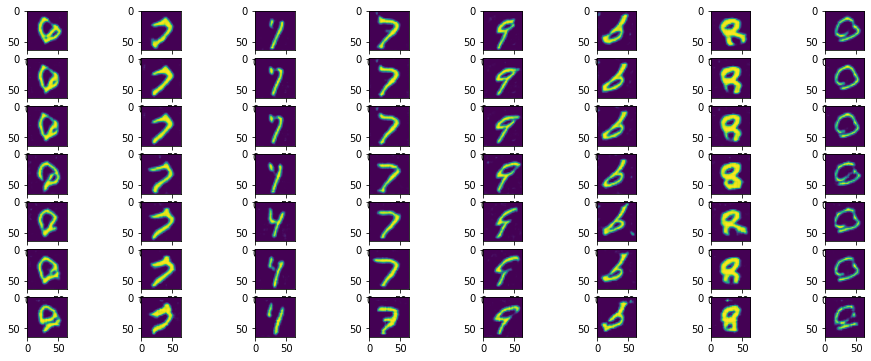

In [ ]:
f, axes = plt.subplots(7, 8, sharex=False, sharey=False)
f.set_size_inches((16, 6)) 
for i, img_list in enumerate(generated_img_list[-7:]):
  for j, img in enumerate(img_list):
    axes[i,j].imshow(img.reshape(64, 64))
# 고정된 8개의 z 벡터에 대해 생성된 마지막 7개 이미지. 아래로 갈수록 초반 에포크 이미지이다. 점점 생성된 이미지가 변화하면서 나아지는 모습이다.

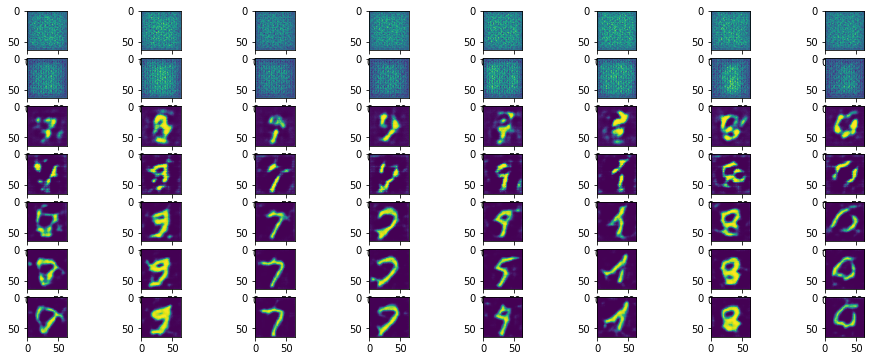

In [ ]:
f, axes = plt.subplots(7, 8, sharex=False, sharey=False)
f.set_size_inches((16, 6)) 
for i, img_list in enumerate(generated_img_list[:7]):
  for j, img in enumerate(img_list):
    axes[i,j].imshow(img.reshape(64, 64)) 
    # 초반 7개 이미지 모습. 확실히 점점 이미지가 선명해지는 모습을 보이는 것 같다. 